In [2]:
import os,sys
import json
import torch
from PIL import Image
from torch.utils.data import DataLoader
import torch.optim as optim


PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

In [14]:
from src.model import TwoLayerConvGRUNet
from src.utils import load_checkpoint

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ckpt_path = "../checkpoints/convrnn_GN.pt"  # 你的实际路径
model = TwoLayerConvGRUNet().to(device)

model = load_checkpoint(model,optimizer= None, path=ckpt_path,map_location=device)

model.eval()


d:\github file\REVAE\src\utils.py:156: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path, map_location=map_location)


TwoLayerConvGRUNet(
  (stem): ConvStem(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): GroupNorm(32, 64, eps=1e-05, affine=True)
    (relu): ReLU(inplace=True)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): GroupNorm(32, 64, eps=1e-05, affine=True)
  )
  (pre1): Conv2d(64, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn_pre1): GroupNorm(32, 96, eps=1e-05, affine=True)
  (rnn1): ConvGRUCell(
    (conv_gates): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_candidate): Conv2d(192, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (down12): Conv2d(96, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn_down12): GroupNorm(32, 128, eps=1e-05, affine=True)
  (rnn2): ConvGRUCell(
    (conv_gates): Conv2d(256, 256, kernel_size=(3,

In [3]:
# 构建数据集
from torch.utils.data import DataLoader,Subset
from src.dataset import build_global_vocab_and_maxcount, CLEVRMultiLabelByImage

clevr_root = "../CLEVR_v1.0"

# 全局统计：colors/shapes/max_objects（train+val+test）
colors = ['blue', 'brown', 'cyan', 'gray', 'green', 'purple', 'red', 'yellow']
shapes = ['cube', 'cylinder', 'sphere']
max_objects = 10

val_ds = CLEVRMultiLabelByImage(
    clevr_root=clevr_root,
    split="val",
    colors=colors,
    shapes=shapes,
    max_objects=max_objects,
)

# 取前 N 个样本（最快、可复现）
N = 2000

val_ds_small = Subset(val_ds, list(range(N)))

val_dl = DataLoader(val_ds, batch_size=100, shuffle=True, num_workers=0)


In [12]:
img, color_mh, shape_mh, count_oh, color_count, shape_count = val_ds_small[10]  # 取第0个样本
print(img.shape)        # torch.Size([3, 224, 224])
print(color_mh.shape)   # torch.Size([8])
print(shape_mh.shape)   # torch.Size([3])
print(count_oh.shape)   # torch.Size([11])
print(color_count.shape)
print(shape_count.shape)

torch.Size([3, 224, 224])
torch.Size([8])
torch.Size([3])
torch.Size([11])
torch.Size([8, 11])
torch.Size([3, 11])


In [13]:
present_colors = [colors[i] for i, v in enumerate(color_mh.tolist()) if v == 1.0]
present_shapes = [shapes[i] for i, v in enumerate(shape_mh.tolist()) if v == 1.0]
total_count = int(count_oh.argmax().item())

print("colors:", present_colors)
print("shapes:", present_shapes)
print("count:", total_count)


colors: ['green', 'purple']
shapes: ['cube', 'cylinder']
count: 5


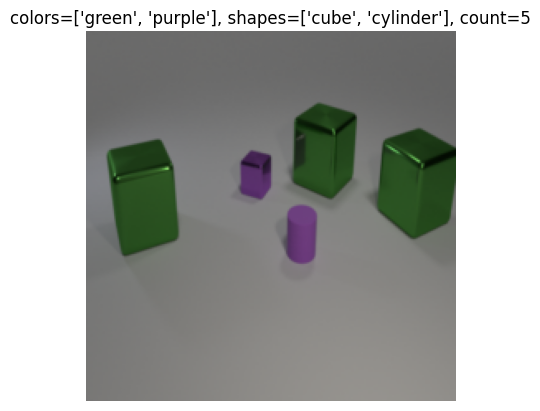

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# 3) 显示图像（Tensor CHW -> HWC）
img_np = img.detach().cpu().numpy().transpose(1, 2, 0)  # (224,224,3)
img_np = np.clip(img_np, 0, 1)  # 你没做normalize的话，这句可留着防止超界

plt.figure()
plt.imshow(img_np)
plt.axis("off")
plt.title(f"colors={present_colors}, shapes={present_shapes}, count={total_count}")
plt.show()

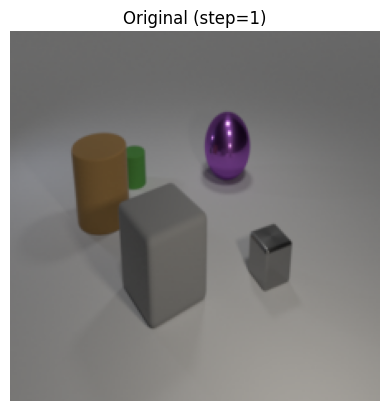

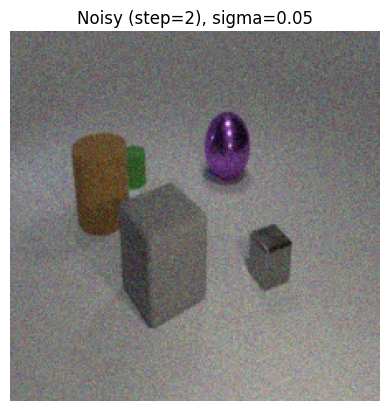

In [11]:
# 简单高斯加噪（强度可控）
sigma = 0.05  # 噪声强度：0.05轻 / 0.15中 / 0.30强
img_noisy = (img + torch.randn_like(img) * sigma).clamp(0.0, 1.0)

# show 对比：原图 vs 加噪后
plt.figure()
plt.imshow(img.detach().cpu().numpy().transpose(1, 2, 0).clip(0, 1))
plt.axis("off")
plt.title("Original (step=1)")
plt.show()

plt.figure()
plt.imshow(img_noisy.detach().cpu().numpy().transpose(1, 2, 0).clip(0, 1))
plt.axis("off")
plt.title(f"Noisy (step=2), sigma={sigma}")
plt.show()


In [19]:
# 一张图像及其对应的全部信息：图+颜色种类+数量+颜色：数量
# 一张图像拿模型测出的全部信息：图+颜色种类+数量+颜色：数量
# 一批图像直接拿模型去测的统计信息

In [20]:
def predict(model, image, threshold=0.5, colors=None, max_objects=10):
    """
    预测图像的颜色、数量以及颜色-数量绑定关系。

    参数：
        - model: 已加载训练的模型
        - image: 输入图像 (PIL image 或 torch.Tensor)
        - threshold: 预测概率的阈值（默认为0.5）
        - colors: 颜色标签的顺序（如 ["red", "green", ...]）
        - max_objects: 最大物体数量（通常10）

    返回：
        - 预测结果：颜色、数量、颜色-数量绑定
    """
    # 确保输入是一个批量的图像
    if isinstance(image, Image.Image):
        image = image.convert("RGB")  # 确保是 RGB 格式
        image = image.resize((224, 224))  # 适配输入尺寸
        image = np.array(image)  # 转为 numpy 数组
        image = torch.tensor(image).permute(2, 0, 1).float() / 255.0  # 转为 [C, H, W] 并归一化
        image = image.unsqueeze(0)  # 加上 batch 维度 (1, C, H, W)
    elif isinstance(image, torch.Tensor):
        if image.dim() == 3:  # (C, H, W) -> (1, C, H, W)
            image = image.unsqueeze(0)  # 加上 batch 维度 (1, C, H, W)
    else:
        raise TypeError("Expected input image type to be PIL Image or torch Tensor")

    image = image.to(device)  # 将图像传到 GPU/CPU

    # 推理
    with torch.no_grad():
        logits_colors, logits_counts, logits_color_count = model(image, steps=3)

    # 处理颜色预测 (logits_colors: [B, steps, 8])
    probs_colors = torch.sigmoid(logits_colors)  # 转化为概率
    preds_colors = (probs_colors >= threshold).float()  # 阈值化
    predicted_colors = preds_colors.squeeze(0).cpu().numpy()  # (steps, 8)

    # 提取颜色标签
    color_predictions = []
    for step in range(predicted_colors.shape[0]):
        present_colors = [colors[i] for i in range(predicted_colors.shape[1]) if predicted_colors[step, i] == 1]
        color_predictions.append(present_colors)

    # 处理数量预测 (logits_counts: [B, steps, 11])
    probs_counts = torch.sigmoid(logits_counts)
    preds_counts = torch.argmax(probs_counts, dim=2).squeeze(0).cpu().numpy()  # 获取每步的最大概率类
    count_predictions = preds_counts  # 直接是每个 step 对应的数量（0-10）

    # 处理颜色和数量绑定的预测 (logits_color_count: [B, steps, 8, 11])
    probs_color_count = torch.sigmoid(logits_color_count)
    preds_color_count = torch.argmax(probs_color_count, dim=3).squeeze(0).cpu().numpy()  # 预测每个颜色的数量
    color_count_predictions = preds_color_count  # 形状为 [steps, 8, 11]，表示每个颜色的数量分布

    return color_predictions, count_predictions, color_count_predictions

color_predictions, count_predictions, color_count_predictions = predict(model, img, threshold=0.5, colors=colors, max_objects=10)

print("Color Predictions:", color_predictions)
print("Count Predictions:", count_predictions)
print("Color-Count Predictions:", color_count_predictions)


Color Predictions: [['cyan', 'green', 'red'], ['cyan', 'green', 'red'], ['cyan', 'green', 'red']]
Count Predictions: [4 4 4]
Color-Count Predictions: [[0 0 1 0 2 0 1 0]
 [0 0 1 0 2 0 1 0]
 [0 0 1 0 2 0 1 0]]


In [21]:
import torch

@torch.no_grad()
def eval_color_strict_on_loader(model, dataloader, device, steps=3, threshold=0.5):
    model.eval() 

    correct_sum = torch.zeros(steps, device=device)
    wrong_sum   = torch.zeros(steps, device=device)

    for batch in dataloader:
        # 兼容你 dataset 返回 5 个或更多字段：只取前两个
        images = batch[0].to(device)      # (B,3,224,224)
        targets = batch[1].to(device)     # (B,8) color_mh

        # forward：拿到颜色 logits 序列
        out = model(images, steps=steps)
        # 兼容两种 model 输出：
        # - 纯颜色模型：直接返回 logits_colors
        # - 多 head 模型：返回 (logits_colors, logits_counts, logits_color_count, ...)
        logits_seq = out if torch.is_tensor(out) else out[0]   # (B,steps,8)

        # ---- strict 统计（和你 loss_color 里一致）----
        probs = torch.sigmoid(logits_seq)                 # (B,S,8)
        preds = (probs >= threshold).float()              # (B,S,8)

        B, S, C = preds.shape
        assert S == steps, f"model 输出 steps={S}，但你传入 steps={steps}"

        for t in range(steps):
            eq = (preds[:, t, :] == targets.float())      # (B,8)
            all_ok = eq.all(dim=1)                        # (B,)
            n_ok = all_ok.sum()
            correct_sum[t] += n_ok
            wrong_sum[t] += (B - n_ok)

    total = correct_sum + wrong_sum
    acc = correct_sum / torch.clamp(total, min=1.0)

    return {
        "correct_per_step": correct_sum.detach().cpu(),
        "wrong_per_step": wrong_sum.detach().cpu(),
        "acc_per_step": acc.detach().cpu(),
        "num_samples_per_step": total.detach().cpu(),
    }

# ------- 运行统计 -------
stats = eval_color_strict_on_loader(
    model=model,
    dataloader=val_dl,   # 你的训练 DataLoader
    device=device,
    steps=3,               # 改成你训练时用的 steps
    threshold=0.5,
)

print("correct_per_step:", stats["correct_per_step"].tolist())
print("wrong_per_step  :", stats["wrong_per_step"].tolist())
print("acc_per_step    :", [float(x) for x in stats["acc_per_step"]])
print("num_samples     :", stats["num_samples_per_step"].tolist())


correct_per_step: [14828.0, 14861.0, 14873.0]
wrong_per_step  : [172.0, 139.0, 127.0]
acc_per_step    : [0.9885333180427551, 0.9907333254814148, 0.9915333390235901]
num_samples     : [15000.0, 15000.0, 15000.0]
